# Wikipedia Album Info Extract

Scrape Wikipedia For Albums Released by Year

In [1]:
import os
import re
from urllib.parse import urljoin
import datetime as dt

import requests
from bs4 import BeautifulSoup
import sqlite3
import pandas as pd

import matplotlib.pyplot as plt

from IPython.display import display, HTML

In [80]:
%run ./url_cache.ipynb
%run ./wikipedia_access.ipynb

## Initialize DB

In [3]:
os.makedirs("var/data", exist_ok=True)
db = sqlite3.Connection("var/data/music.db")

## Core Code Components and Setup

In [81]:
url_cache = URLContentCacheSqlite(db)
w_album_info = WikipediaAlbumInfo(url_cache)
album_extractor = WikiListPageAlbumExtractor(url_cache)

## Prime List of Pages for Each Year

In [5]:
year_list_urls = w_album_info.get_year_urls()
year_list_urls

,year,title,url
18,2022,List of 2022 albums,https://en.wikipedia.org/wiki/List_of_2022_albums
17,2021,List of 2021 albums (July–December),https://en.wikipedia.org/wiki/List_of_2021_alb...
16,2021,List of 2021 albums (January–June),https://en.wikipedia.org/wiki/List_of_2021_alb...
15,2020,List of 2020 albums,https://en.wikipedia.org/wiki/List_of_2020_albums
14,2019,List of 2019 albums,https://en.wikipedia.org/wiki/List_of_2019_albums
...,...,...,...
23,1942,List of 1942 albums,https://en.wikipedia.org/wiki/List_of_1942_albums
22,1941,List of 1941 albums,https://en.wikipedia.org/wiki/List_of_1941_albums
21,1940,List of 1940 albums,https://en.wikipedia.org/wiki/List_of_1940_albums
20,1939,List of 1939 albums,https://en.wikipedia.org/wiki/List_of_1939_albums


In [6]:
# Download lists to cache
for _url in year_list_urls.url:
    print(f"Downloading: {_url}")
    url_cache.get(_url)

Downloading: https://en.wikipedia.org/wiki/List_of_2022_albums
Downloading: https://en.wikipedia.org/wiki/List_of_2021_albums_(July%E2%80%93December)
Downloading: https://en.wikipedia.org/wiki/List_of_2021_albums_(January%E2%80%93June)
Downloading: https://en.wikipedia.org/wiki/List_of_2020_albums
Downloading: https://en.wikipedia.org/wiki/List_of_2019_albums
Downloading: https://en.wikipedia.org/wiki/List_of_2018_albums
Downloading: https://en.wikipedia.org/wiki/List_of_2017_albums
Downloading: https://en.wikipedia.org/wiki/List_of_2016_albums
Downloading: https://en.wikipedia.org/wiki/List_of_2015_albums
Downloading: https://en.wikipedia.org/wiki/List_of_2014_albums
Downloading: https://en.wikipedia.org/wiki/List_of_2013_albums
Downloading: https://en.wikipedia.org/wiki/List_of_2012_albums
Downloading: https://en.wikipedia.org/wiki/List_of_2011_albums
Downloading: https://en.wikipedia.org/wiki/List_of_2010_albums
Downloading: https://en.wikipedia.org/wiki/List_of_2009_albums
Download

## Examine All Dataframes To Determine Valid Meta Data

In [21]:
all_dfs = album_extractor.get_all_dataframes(year_list_urls)

[WARN] Could not extract table - invalid literal for int() with base 10: '3"'
[WARN] Could not extract table - invalid literal for int() with base 10: '1" valign="top"'


In [52]:
df_w_album = [df for df in all_dfs if "Album" in df.columns][0]
df_w_album.head(10)

,Release date,Artist,Album,Genre,Label,Ref.,links,year
0,January7,RuPaul,Mamaru,,RuCo Inc,[1],"{'Artist': [{'href': '/wiki/RuPaul', 'text': '...",2022
1,January7,Twin Atlantic,Transparency,,,[2],"{'Artist': [{'href': '/wiki/Twin_Atlantic', 't...",2022
2,January7,The Wombats,"Fix Yourself, Not the World",,AWAL,[3],"{'Artist': [{'href': '/wiki/The_Wombats', 'tex...",2022
3,January7,Years & Years,Night Call,,Polydor,[4],"{'Artist': [{'href': '/wiki/Years_%26_Years', ...",2022
4,January14,Fickle Friends,Are We Gonna Be Alright?,,,[5],"{'Artist': [{'href': '/wiki/Fickle_Friends', '...",2022
5,January14,The Lumineers,Brightside,,,[6],"{'Artist': [{'href': '/wiki/The_Lumineers', 't...",2022
6,January14,Magnum,The Monster Roars,,"SPV, Steamhammer",[7],"{'Artist': [{'href': '/wiki/Magnum_(band)', 't...",2022
7,January14,Sea Girls,Homesick,,,[8],"{'Artist': [{'href': '/wiki/Sea_Girls', 'text'...",2022
8,January14,Underoath,Voyeurist,,Fearless,[9],"{'Artist': [{'href': '/wiki/Underoath', 'text'...",2022
9,January21,Aoife O'Donovan,Age of Apathy,,Yep Roc,[10],{'Artist': [{'href': '/wiki/Aoife_O%27Donovan'...,2022


In [22]:
def get_column_info(dfs):
    col_info = []
    for dfid, df in enumerate(dfs):
        for col in df.columns:
            if col not in {'links', 'year'}:
                col_info.append({ 'year': df.year.iloc[0], 'column': col, 'dfid': dfid })
    return pd.DataFrame(col_info)

def get_column_year_stats(col_info):
    col_stats = (col_info
        .groupby(['column', 'year'])
        .size()
        .reset_index()
        .rename(columns={0: 'Count'})
        .groupby(['column'])
        .agg({'year': 'size', 'Count': 'sum'})
        .reset_index()
        .rename(columns={'year': 'YearCount'})
        .sort_values(by='Count', ascending=False)
    )
    col_stats['column'] = col_stats.column.astype(str)
    return col_stats

col_info = get_column_info(all_dfs)
col_stats = get_column_year_stats(col_info)

In [23]:
col_stats.head(20)

,column,YearCount,Count
5,Artist,84,603
3,Album,60,530
23,Notes,42,318
14,Day,19,228
28,Ref.,18,210
19,Label,18,210
16,Genre,18,210
30,Release date,18,208
46,Unnamed:0,67,185
47,Unnamed:1,67,185


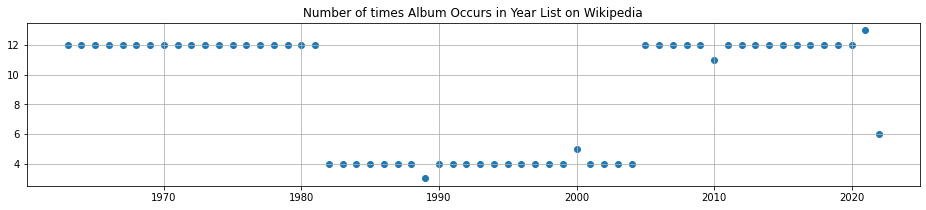

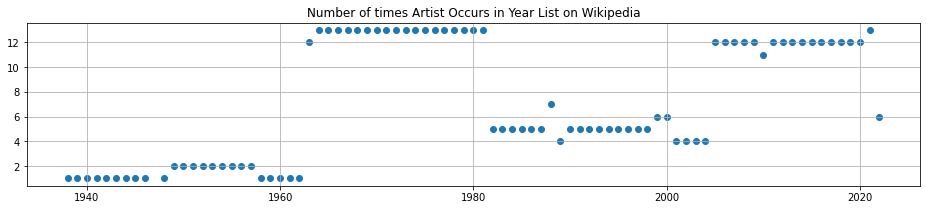

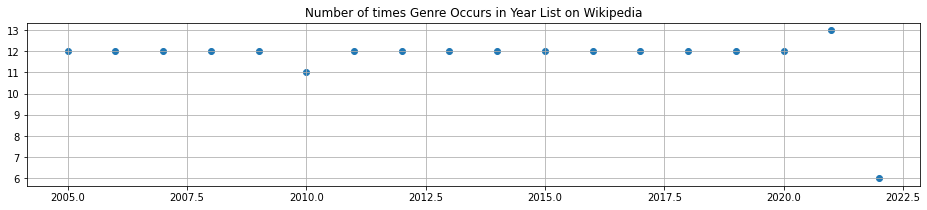

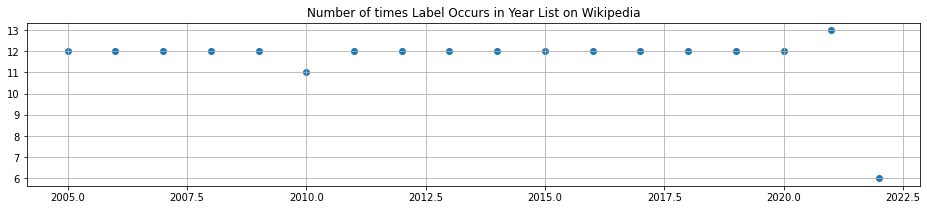

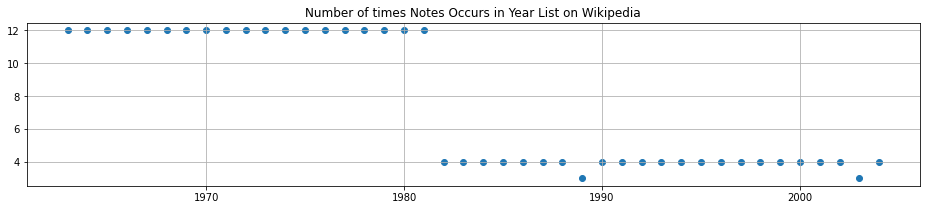

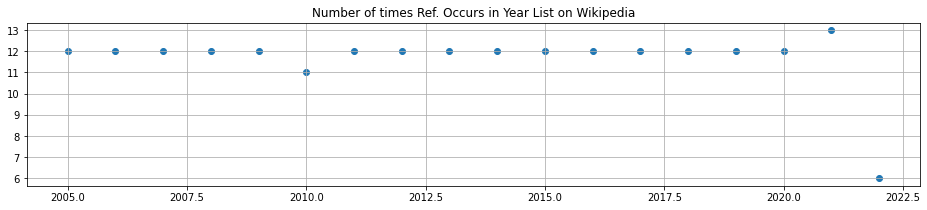

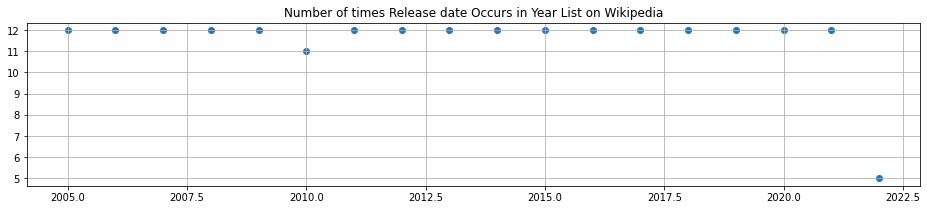

In [25]:
# It looks like the table with a column Album isn't really used prior to 1963
# The 1990s and early 2000 entries have tables by quarter while
# Many other years have tables by month.

col_stats_top = col_stats[
    (col_stats.column.str.len() > 3) &
    (~col_stats.column.str.contains('Unnamed'))
].head(7)

col_yc = (col_info[col_info.column.isin(set(col_stats_top.column))]
    .groupby(['year', 'column'])
    .size()
    .reset_index()
    .rename(columns = {0: 'Count'})
    .sort_values(by=['column', 'year'])
)

for c, c_df in col_yc.groupby('column'):
    plt.figure(figsize=(16, 3))
    plt.title(f"Number of times {c} Occurs in Year List on Wikipedia")
    plt.scatter(c_df.year, c_df.Count, label=c)
    plt.grid(1)
    plt.show()

In [26]:
years_no_album = list(set(col_info.year.unique()) - set(col_info[col_info.column == 'Album'].year.unique()))
years_no_album.sort()
years_no_album

[1938,
 1939,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962]

## Album Info

In [82]:
albums = album_extractor.get_all_albums(year_list_urls)

[WARN] Could not extract table - invalid literal for int() with base 10: '3"'
[WARN] Could not extract table - invalid literal for int() with base 10: '1" valign="top"'


In [87]:
albums['Artist'] = albums.Artist.astype(str)

In [109]:
# Where is the money store?
albums[albums.Artist.str.contains('Death Grip')]

,Artist,Album,Genre,Label,year,links
4414,Death Grips,Year of the Snitch,"Industrial hip hop, experimental hip hop","Third Worlds, Harvest",2018,"{'Artist': [{'href': '/wiki/Death_Grips', 'tex..."
5958,Death Grips,Bottomless Pit,"Experimental hip hop, digital hardcore",Third Worlds,2016,"{'Artist': [{'href': '/wiki/Death_Grips', 'tex..."
6596,Death Grips,The Powers That B,Experimental hip hop,"Third Worlds, Harvest",2015,"{'Artist': [{'href': '/wiki/Death_Grips', 'tex..."


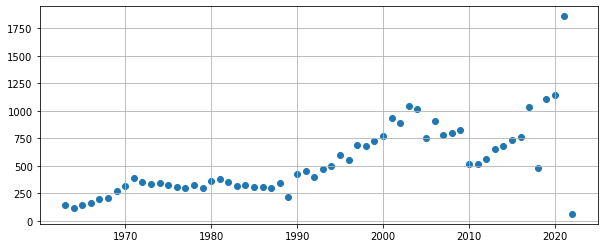

In [102]:
album_counts_by_year = albums.groupby('year').size().reset_index().rename(columns={0: 'Count'}).sort_values(by='year')

plt.figure(figsize=(10, 4))
plt.scatter(album_counts_by_year.year, album_counts_by_year.Count)
plt.grid(1)
plt.show()

## Examine Pre 1963 Page Info

Working on code to extract albums from list format.

In [64]:
no_album_sample = year_list_urls[year_list_urls.year < 1963].sample(1).iloc[0]
no_album_sample

year                                                  1938
title                                  List of 1938 albums
url      https://en.wikipedia.org/wiki/List_of_1938_albums
Name: 19, dtype: object

In [65]:
no_album_html = url_cache.get(no_album_sample.url)['content']

In [66]:
h_doc = BeautifulSoup(no_album_html)

In [67]:
class ListExtractor:
    
    HEADER_RE = re.compile(r'h[1-7]')
    
    @staticmethod
    def get_all_lists(h):
        if not isinstance(h, BeautifulSoup):
            h = BeautifulSoup(h)
        
        lists = []
        for ul_tag in h.find_all('ul'):
            lists.append(ListExtractor.get_list(ul_tag))
        return lists
    
    @staticmethod
    def get_list(list_tag):
        prev_header = list_tag.find_previous(ListExtractor.HEADER_RE)
        if prev_header is not None:
            list_title = prev_header.text
        else:
            list_title = None
            
        items = []
        for li_tag in list_tag.find_all('li'):
            item = {
                'text': li_tag.text
            }
            links = []
            for a_tag in li_tag.find_all('a'):
                if 'href' in a_tag.attrs:
                    links.append({ 'href': a_tag.attrs['href'], 'text': a_tag.text })
            if len(links) > 0:
                item['links'] = links

            items.append(item)

        return { 'title': list_title, 'items': items }
            

In [70]:
all_lists = []
for _, year_list_row in year_list_urls[year_list_urls.year < 1963].iterrows():
    page_html = url_cache.get(year_list_row.url)['content']
    for l in ListExtractor.get_all_lists(page_html):
        l['year'] = year_list_row['year']
        all_lists.append(l)

In [72]:
all_lists = pd.DataFrame(all_lists)

In [77]:
all_lists[all_lists['title'].str.contains('Album')].iloc[0]['items']

[{'text': 'Adam Faith – Adam Faith',
  'links': [{'href': '/wiki/Adam_Faith', 'text': 'Adam Faith'}]},
 {'text': 'After Hours – Joni James',
  'links': [{'href': '/wiki/Joni_James', 'text': 'Joni James'}]},
 {'text': 'Alice Faye Sings Her Famous Movie Hits – Alice Faye',
  'links': [{'href': '/wiki/Alice_Faye', 'text': 'Alice Faye'}]},
 {'text': 'Along Comes Ruth – Ruth Brown',
  'links': [{'href': '/wiki/Ruth_Brown', 'text': 'Ruth Brown'}]},
 {'text': 'All Aboard the Blue Train – Johnny Cash',
  'links': [{'href': '/wiki/All_Aboard_the_Blue_Train',
    'text': 'All Aboard the Blue Train'},
   {'href': '/wiki/Johnny_Cash', 'text': 'Johnny Cash'}]},
 {'text': 'All Alone – Frank Sinatra',
  'links': [{'href': '/wiki/All_Alone_(Frank_Sinatra_album)',
    'text': 'All Alone'},
   {'href': '/wiki/Frank_Sinatra', 'text': 'Frank Sinatra'}]},
 {'text': "All the Sad Young Men – Anita O'Day",
  'links': [{'href': '/wiki/All_the_Sad_Young_Men_(album)',
    'text': 'All the Sad Young Men'},
   {'h

In [38]:
display(HTML(no_album_html))